<a href="https://colab.research.google.com/github/jacobholmshaw/biological-image-classification/blob/main/finalopt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


# Setup

In [ ]:
pip install git+git://github.com/Hvass-Labs/scikit-optimize.git@dd7433da068b5a2509ef4ea4e5195458393e6555

  Cloning git://github.com/Hvass-Labs/scikit-optimize.git (to revision dd7433da068b5a2509ef4ea4e5195458393e6555) to /tmp/pip-req-build-kjthrw27
  Running command git clone -q git://github.com/Hvass-Labs/scikit-optimize.git /tmp/pip-req-build-kjthrw27
  Running command git rev-parse -q --verify 'sha^dd7433da068b5a2509ef4ea4e5195458393e6555'
  Running command git fetch -q git://github.com/Hvass-Labs/scikit-optimize.git dd7433da068b5a2509ef4ea4e5195458393e6555
  Running command git checkout -q dd7433da068b5a2509ef4ea4e5195458393e6555


In [ ]:
pip install h5py scikit-optimize

In [ ]:
pip install git+https://github.com/aleju/imgaug.git

  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-k2974l3x
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-k2974l3x


In [ ]:
import tensorflow as tf  # version 2.5
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU, Softmax
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.layers import Dense, Flatten, Dropout, Reshape, Activation
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta, Adamax, SGD, Ftrl, Nadam, RMSprop
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [ ]:
# skopt functions
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
import tensorflow as tf
import imgaug as ia
import numpy as np
import matplotlib.pyplot as plt
import PIL
from pathlib import Path
from tensorflow.keras import layers
from imgaug import augmenters as iaa
import imageio
from PIL import Image
import os, sys
import random
import cv2
import imutils
from datetime import datetime
from keras import regularizers
from google.colab import files
import math

In [ ]:
os.chdir(os.getcwd()+'/drive/MyDrive/Hypothalamus machine learning/Data')
path = os.getcwd()
DATADIR = path+'/labeled_data'

# The following methods don't work with the DATADIR as a string, therefore we convert it to a path using Path from pathlib
DATADIR = Path(DATADIR)

#Sub directories for different categories
CATEGORIES = ["10_1","10_2","10_3"]

print('Path:', path)
print('Data directory:', DATADIR)

Path: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data
Data directory: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/labeled_data


In [ ]:
parent = os.path.join(path, os.pardir)
modelDIR = os.path.abspath(parent) + '/Models'
plotDIR = os.path.abspath(parent) + '/Plots/augmentation_acc_loss_plots'
# prints parent directory
print("\nParent Directory:", os.path.abspath(parent))
print("Model directory:", modelDIR)
print("Plots directory:", plotDIR)


Parent Directory: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning
Model directory: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models
Plots directory: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Plots/augmentation_acc_loss_plots


# Load data

In [ ]:
tdata = []

for img in os.listdir('labeled_data/10_1'):  # iterate over each image
    try:
        img_array = cv2.imread('labeled_data/10_1/{}'.format(img), cv2.IMREAD_GRAYSCALE) 
        tdata.append([cv2.resize(img_array, (200, 200)), 0])
    except Exception as e:  
        pass

for img in os.listdir('labeled_data/10_2'):  # iterate over each image
    try:
        img_array = cv2.imread('labeled_data/10_2/{}'.format(img), cv2.IMREAD_GRAYSCALE) 
        tdata.append([cv2.resize(img_array, (200, 200)), 1])
    except Exception as e:  
        pass

for img in os.listdir('labeled_data/10_3'):  # iterate over each image
    try:
        img_array = cv2.imread('labeled_data/10_3/{}'.format(img), cv2.IMREAD_GRAYSCALE) 
        tdata.append([cv2.resize(img_array, (200, 200)), 2])
    except Exception as e:  
        pass

# Hyperparams

In [ ]:
# dim_learning_rate = Real(low=1e-6, high=1e-4, prior='log-uniform',
#                          name='learning_rate')
dim_learning_rate = Categorical(categories = [0.000001, 0.00001, 0.0001],
                                name = 'learning_rate')
dim_lamda = Categorical(categories = [0.000001, 0.00001, 0.0001],
                                name = 'lamda')

dim_layer_drop = Real(low = 0.01, high = 0.25, prior = 'log-uniform', name = 'layer_drop')
dim_final_drop = Real(low = 0.01, high = 0.4, prior = 'log-uniform', name = 'final_drop')
# dim_lamda = Real(low = 1e-6, high = 1e-4, prior = 'log-uniform',
#                  name = 'lamda')

dimensions = [dim_learning_rate,
              dim_layer_drop,
              dim_final_drop,
              dim_lamda]

default_parameters = [0.0001, 0.2, 0.4, 0.0001]

# Opt function

In [ ]:
best_accuracy = 0.0
@use_named_args(dimensions)
def optimise(learning_rate,
             layer_drop,
             final_drop,
             lamda):
  
  print('Learning rate:', learning_rate)
  print('Layer dropout: {}%'.format(round(layer_drop*100, 1)))
  print('Final dropout: {}%'.format(round(final_drop*100, 1)))
  print('Lambda:', lamda)

  valaccs = []
  vallosses = []
  accs = []
  acclosses = []
  testaccs = []
  testlosses = []
  for i in range(10):

    random.shuffle(tdata)
    training_data = tdata[0:int(round(len(tdata)*0.8, 0))]
    val_data = tdata[int(round(len(tdata)*0.8, 0)):int(round(len(tdata), 0))]
    # test_data = tdata[int(round(len(tdata)*0.95, 0)):int(round(len(tdata), 0))]

    train = []
    for feature, label in training_data:
      for angle in np.arange(0, 360, 10):
        feature = cv2.equalizeHist(feature)
        cutout = iaa.Cutout()
        feature2 = cutout(image = feature)
        rotate = iaa.geometric.Affine(rotate = angle)
        feature = rotate(image = feature)
        feature2 = rotate(image = feature2)
        train.append([feature, label])
        train.append([feature2, label])

    val = []
    for feature, label in val_data:
      for angle in np.arange(0, 360, 10):
        feature = cv2.equalizeHist(feature)
        cutout = iaa.Cutout()
        feature2 = cutout(image = feature)
        rotate = iaa.geometric.Affine(rotate = angle)
        feature = rotate(image = feature)
        feature2 = rotate(image = feature2)
        val.append([feature, label])
        val.append([feature2, label])

    random.shuffle(train)
    random.shuffle(val)
    # random.shuffle(test_data)

    # Preprocessing the data into X_train etc with relevant input shapes
    X_train = []
    y_train = []
    X_val = []
    y_val = []
    X_test = []
    y_test = []
    img_size = 200

    for feature, label in train:
      X_train.append(feature)
      y_train.append(label)

    for feature, label in val:
      X_val.append(feature)
      y_val.append(label)

    # for feature, label in test_data:
    #   X_test.append(feature)
    #   y_test.append(label)

    X_train = np.array(X_train) / 255
    X_val = np.array(X_val) / 255
    # X_test = np.array(X_test) / 255

    X_train = X_train.reshape(X_train.shape[0], 200, 200, 1)
    X_val = X_val.reshape(X_val.shape[0], 200, 200, 1)
    # X_test = X_test.reshape(X_test.shape[0], 200, 200, 1)

    X_train.astype('float32')
    X_val.astype('float32')
    # X_test.astype('float32')

    y_train=to_categorical(y_train)
    y_val=to_categorical(y_val)
    # y_test = to_categorical(y_test)

    print('X_train shape:', np.shape(X_train))
    print('X_val shape:', np.shape(X_val))
    # print('X_test shape:', np.shape(X_test))
    print('y_train shape:', np.shape(y_train))
    print('y_val shape:', np.shape(y_val))
    # print('y_test shape:', np.shape(y_test))

    activation = 'relu'
    model = Sequential([
      layers.Conv2D(16, 3, padding='same', activation= activation, input_shape = (200, 200, 1), kernel_regularizer=regularizers.l2(lamda)),
      layers.Dropout(layer_drop),
      layers.MaxPooling2D((2,2), padding='same'),
      layers.Conv2D(32, 3, padding='same', activation=activation, kernel_regularizer=regularizers.l2(lamda)),
      layers.Dropout(layer_drop),
      layers.MaxPooling2D((2,2), padding='same'),
      layers.Conv2D(64, 3, padding='same', activation=activation, kernel_regularizer=regularizers.l2(lamda)),
      layers.Dropout(layer_drop),
      layers.MaxPooling2D((2,2), padding='same'),
      layers.Conv2D(128, 3, padding='same', activation=activation, kernel_regularizer=regularizers.l2(lamda)),
      layers.Dropout(layer_drop),
      layers.MaxPooling2D((2,2), padding='same'),
      layers.Conv2D(256, 3, padding='same', activation=activation, kernel_regularizer=regularizers.l2(lamda)),
      layers.Dropout(layer_drop),
      layers.MaxPooling2D((2,2), padding='same'),
      layers.Conv2D(512, 3, padding='same', activation=activation, kernel_regularizer=regularizers.l2(lamda)),
      layers.Dropout(layer_drop),
      layers.MaxPooling2D((2,2), padding='same'),
      layers.Conv2D(1024, 3, padding='same', activation=activation, kernel_regularizer=regularizers.l2(lamda)),
      layers.Dropout(layer_drop),
      layers.MaxPooling2D((2,2), padding='same'),
      layers.Flatten(),
      layers.Dense(1024, activation=activation),
      layers.Dropout(final_drop),
      layers.Dense(3, activation = 'softmax')
    ])
    model.compile(optimizer = Adam(learning_rate = learning_rate),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

    earlyStop = EarlyStopping(monitor = 'val_loss', min_delta = 0.01, patience = 5)
    epochs = 50
    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=epochs,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[earlyStop])

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['val_accuracy'][-1]

    valaccs.append(round(max(val_acc)*100, 1))
    vallosses.append(round(min(val_loss)*100, 1))
    accs.append(round(max(acc)*100, 1))
    acclosses.append(round(min(loss)*100, 1))

    del model
    K.clear_session()

  print('Accuracies:', accs)
  print('Average accuracy:', round(np.mean(accs),1))
  print('Average loss:', round(np.mean(acclosses),1))
  print('Accuracy standard deviation:', np.std(accs))
  print('Validation accuracies:', valaccs)
  print('Average validation accuracy:', round(np.mean(valaccs), 1))
  print('Average validation loss:', round(np.mean(vallosses),1))
  print('Validation standard deviation:', round(np.std(valaccs), 1))

  final_acc = round(np.mean(valaccs), 1)

  global best_accuracy

  if final_acc > best_accuracy:

      best_accuracy = final_acc

  return -final_acc

# Running

In [ ]:
%%time
search_result = gp_minimize(func=optimise,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=15,
                            x0 = default_parameters)

Learning rate: 0.0001
Layer dropout: 20.0%
Final dropout: 50.0%
Lambda: 0.0001
X_train shape: (8712, 200, 200, 1)
X_val shape: (2160, 200, 200, 1)
y_train shape: (8712, 3)
y_val shape: (2160, 3)
Epoch 1/50
273/273 [==============================] - 25s 32ms/step - loss: 1.1760 - accuracy: 0.4122 - val_loss: 1.2002 - val_accuracy: 0.2644
Epoch 2/50
273/273 [==============================] - 8s 29ms/step - loss: 0.8852 - accuracy: 0.6144 - val_loss: 1.1271 - val_accuracy: 0.5306
Epoch 3/50
273/273 [==============================] - 8s 29ms/step - loss: 0.4578 - accuracy: 0.8582 - val_loss: 1.3374 - val_accuracy: 0.4685
Epoch 4/50
273/273 [==============================] - 8s 29ms/step - loss: 0.2438 - accuracy: 0.9490 - val_loss: 1.3136 - val_accuracy: 0.5856
Epoch 5/50
273/273 [==============================] - 8s 29ms/step - loss: 0.1691 - accuracy: 0.9760 - val_loss: 1.2338 - val_accuracy: 0.6347
Epoch 6/50
273/273 [==============================] - 8s 29ms/step - loss: 0.1435 - accur

# Plots

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

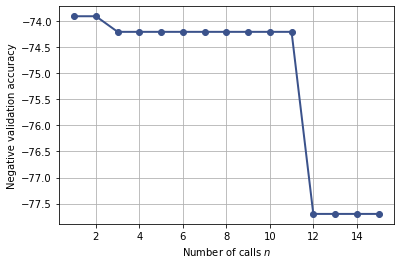

In [ ]:
plot_convergence(search_result)
plt.savefig('conv.png')
files.download('conv.png')

In [ ]:
space = search_result.space
space.point_to_dict(search_result.x)

{'final_drop': 0.9499999999999998,
 'lamda': 4.256458982460014e-06,
 'layer_drop': 0.01,
 'learning_rate': 9.112642150822196e-05}

In [ ]:
sorted(zip(search_result.func_vals, search_result.x_iters))

[(-77.7,
  [9.112642150822196e-05, 0.01, 0.9499999999999998, 4.256458982460014e-06]),
 (-74.2,
  [0.00028671361003280115,
   0.14664609667732945,
   0.4551818170519723,
   3.7848617028011124e-05]),
 (-73.9, [0.0001, 0.2, 0.5, 0.0001]),
 (-73.5,
  [0.0002079462776007808,
   0.04254901409745867,
   0.4307850508647072,
   0.00019635148761700013]),
 (-71.7,
  [0.00021471324454155086,
   0.03705985892170094,
   0.9268752316921398,
   1.8179941988286893e-06]),
 (-71.5,
  [1.8880777708143e-05, 0.01, 0.8348844684525745, 1.0593806509653007e-05]),
 (-71.4,
  [2.1094668789284225e-05,
   0.028842177205237608,
   0.650190482930602,
   0.0015961951965541795]),
 (-71.3,
  [1.5718957336678638e-05,
   0.027280001693912204,
   0.6438934196688568,
   1.8436443655401922e-06]),
 (-66.9,
  [1.0255881455475499e-05,
   0.05510711292793659,
   0.5008319983876046,
   1.6637893846731183e-06]),
 (-56.4,
  [6.354317463348394e-06,
   0.010558787256519864,
   0.849818946097158,
   0.0007076406933711288]),
 (-39.4,
 

In [ ]:
sorted(zip(search_result.func_vals, search_result.x_iters))[0][0]

-77.7

In [ ]:
acc = []
for i in range(15):
  acc.append(-sorted(zip(search_result.func_vals, search_result.x_iters))[i][0])
lr = []
for i in range(15):
  lr.append((sorted(zip(search_result.func_vals, search_result.x_iters))[i][1])[0])
layer = []
for i in range(15):
  layer.append((sorted(zip(search_result.func_vals, search_result.x_iters))[i][1])[1]*100)
final = []
for i in range(15):
  final.append((sorted(zip(search_result.func_vals, search_result.x_iters))[i][1])[2]*100)
lamdas = []
for i in range(15):
  lamdas.append((sorted(zip(search_result.func_vals, search_result.x_iters))[i][1])[3])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

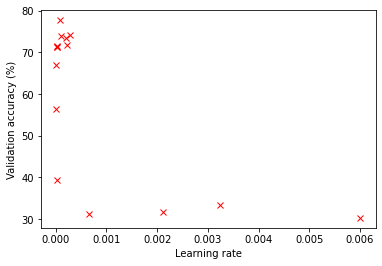

In [ ]:
plt.plot(lr, 
         acc,
         'x',
         color = 'red',
         markersize = 6)
plt.xlabel('Learning rate')
plt.ylabel('Validation accuracy (%)')
plt.savefig('lracc.png')
files.download('lracc.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

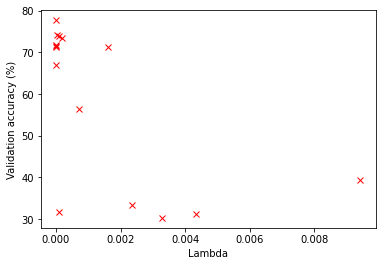

In [ ]:
plt.plot(lamdas, 
         acc,
         'x',
         color = 'red',
         markersize = 6)
plt.xlabel('Lambda')
plt.ylabel('Validation accuracy (%)')
plt.savefig('lambdaacc.png')
files.download('lambdaacc.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

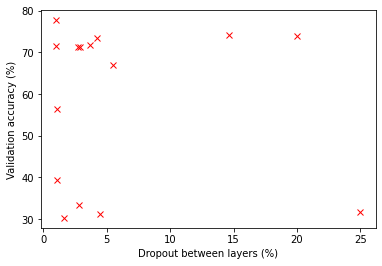

In [ ]:
plt.plot(layer, 
         acc,
         'x',
         color = 'red',
         markersize = 6)
plt.xlabel('Dropout between layers (%)')
plt.ylabel('Validation accuracy (%)')
plt.savefig('layerdropacc.png')
files.download('layerdropacc.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

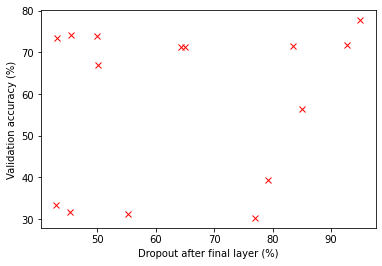

In [ ]:
plt.plot(final, 
         acc,
         'x',
         color = 'red',
         markersize = 6)
plt.xlabel('Dropout after final layer (%)')
plt.ylabel('Validation accuracy (%)')
plt.savefig('finaldropacc.png')
files.download('finaldropacc.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

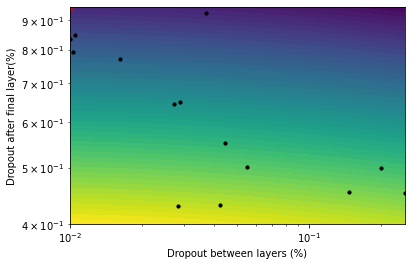

In [ ]:
fig = plot_objective_2D(result=search_result,
                        dimension_name1='layer_drop',
                        dimension_name2='final_drop',
                        levels=50,
                        xlab = 'Dropout between layers (%)',
                        ylab = 'Dropout after final layer(%)')
plt.savefig('dropout_fig.png')
files.download('dropout_fig.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

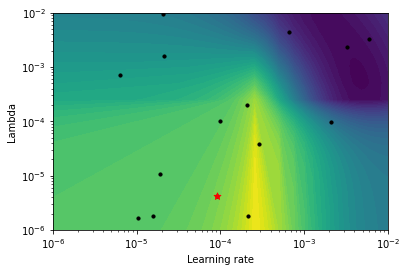

In [ ]:

fig = plot_objective_2D(result=search_result,
                        dimension_name1='learning_rate',
                        dimension_name2='lamda',
                        levels=50,
                        xlab = 'Learning rate',
                        ylab = 'Lambda')
plt.savefig('lr_lambda.png')
files.download('lr_lambda.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

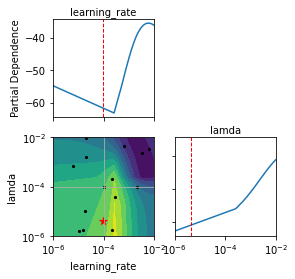

In [ ]:
fig, ax = plot_objective(result=search_result, dimension_names=['learning_rate', 'lamda'])
plt.savefig('lr_lambda_obj.png')
files.download('lr_lambda_obj.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

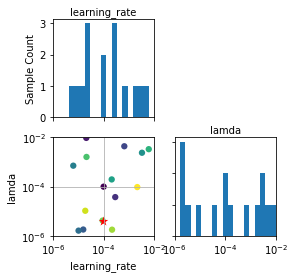

In [ ]:
fig, ax = plot_evaluations(result=search_result, dimension_names= ['learning_rate', 'lamda'])
plt.savefig('lr_lambda_hist.png')
files.download('lr_lambda_hist.png')

# Testing best params

In [ ]:
optimise([9.112642150822196e-05, 0.01, 0.9499999999999998, 4.256458982460014e-06])


Learning rate: 9.112642150822196e-05
Layer dropout: 1.0%
Final dropout: 95.0%
Lambda: 4.256458982460014e-06
X_train shape: (8712, 200, 200, 1)
X_val shape: (2160, 200, 200, 1)
y_train shape: (8712, 3)
y_val shape: (2160, 3)
Epoch 1/50
273/273 [==============================] - 9s 31ms/step - loss: 1.0896 - accuracy: 0.3969 - val_loss: 1.1679 - val_accuracy: 0.2000
Epoch 2/50
273/273 [==============================] - 8s 29ms/step - loss: 1.0770 - accuracy: 0.4007 - val_loss: 1.2092 - val_accuracy: 0.2000
Epoch 3/50
273/273 [==============================] - 8s 29ms/step - loss: 1.0439 - accuracy: 0.4062 - val_loss: 1.1077 - val_accuracy: 0.3861
Epoch 4/50
273/273 [==============================] - 8s 29ms/step - loss: 0.9278 - accuracy: 0.5536 - val_loss: 1.2206 - val_accuracy: 0.4116
Epoch 5/50
273/273 [==============================] - 8s 29ms/step - loss: 0.5808 - accuracy: 0.7656 - val_loss: 0.7027 - val_accuracy: 0.7213
Epoch 6/50
273/273 [==============================] - 8s 29ms

-76.6

# Second run

In [ ]:
random.seed(123)
random.shuffle(tdata)
k = 10
split1 = tdata[int(round(len(tdata)*(0/k), 0)):int(round(len(tdata)*(1/k), 0))]
split2 = tdata[int(round(len(tdata)*(1/k), 0)):int(round(len(tdata)*(2/k), 0))]          
split3 = tdata[int(round(len(tdata)*(2/k), 0)):int(round(len(tdata)*(3/k), 0))]   
split4 = tdata[int(round(len(tdata)*(3/k), 0)):int(round(len(tdata)*(4/k), 0))]  
split5 = tdata[int(round(len(tdata)*(4/k), 0)):int(round(len(tdata)*(5/k), 0))]
split6 = tdata[int(round(len(tdata)*(5/k), 0)):int(round(len(tdata)*(6/k), 0))]
split7 = tdata[int(round(len(tdata)*(6/k), 0)):int(round(len(tdata)*(7/k), 0))]
split8 = tdata[int(round(len(tdata)*(7/k), 0)):int(round(len(tdata)*(8/k), 0))]     
split9 = tdata[int(round(len(tdata)*(8/k), 0)):int(round(len(tdata)*(9/k), 0))]
split10 = tdata[int(round(len(tdata)*(9/k), 0)):int(round(len(tdata)*(10/k), 0))]    

In [ ]:
def visualise_all(data, figsize1 = 10, figsize2 = 10):
  fig = plt.figure(figsize=(figsize1, figsize2))
  for i in range(len(data)):
    plt.subplot((int(math.ceil(np.sqrt(len(data))))), 
                (int(math.ceil(np.sqrt(len(data))))), 
                i+1)
    plt.imshow(data[i][0], cmap = 'gray')
    plt.axis('off')

In [ ]:
split1aug = []
for feature, label in split1:
  for angle in np.arange(0, 360, 10):
      feature = cv2.equalizeHist(feature)
      cutout = iaa.Cutout()
      feature2 = cutout(image = feature)
      rotate = iaa.geometric.Affine(rotate = angle)
      feature = rotate(image = feature)
      feature2 = rotate(image = feature2)
      split1aug.append([feature, label])
      split1aug.append([feature2, label])
  
split2aug = []
for feature, label in split2:
  for angle in np.arange(0, 360, 10):
      feature = cv2.equalizeHist(feature)
      cutout = iaa.Cutout()
      feature2 = cutout(image = feature)
      rotate = iaa.geometric.Affine(rotate = angle)
      feature = rotate(image = feature)
      feature2 = rotate(image = feature2)
      split2aug.append([feature, label])
      split2aug.append([feature2, label])

split3aug = []
for feature, label in split3:
  for angle in np.arange(0, 360, 10):
      feature = cv2.equalizeHist(feature)
      cutout = iaa.Cutout()
      feature2 = cutout(image = feature)
      rotate = iaa.geometric.Affine(rotate = angle)
      feature = rotate(image = feature)
      feature2 = rotate(image = feature2)
      split3aug.append([feature, label])
      split3aug.append([feature2, label])

split4aug = []
for feature, label in split4:
  for angle in np.arange(0, 360, 10):
      feature = cv2.equalizeHist(feature)
      cutout = iaa.Cutout()
      feature2 = cutout(image = feature)
      rotate = iaa.geometric.Affine(rotate = angle)
      feature = rotate(image = feature)
      feature2 = rotate(image = feature2)
      split4aug.append([feature, label])
      split4aug.append([feature2, label])

split5aug = []
for feature, label in split5:
  for angle in np.arange(0, 360, 10):
      feature = cv2.equalizeHist(feature)
      cutout = iaa.Cutout()
      feature2 = cutout(image = feature)
      rotate = iaa.geometric.Affine(rotate = angle)
      feature = rotate(image = feature)
      feature2 = rotate(image = feature2)
      split5aug.append([feature, label])
      split5aug.append([feature2, label])

split6aug = []
for feature, label in split6:
  for angle in np.arange(0, 360, 10):
      feature = cv2.equalizeHist(feature)
      cutout = iaa.Cutout()
      feature2 = cutout(image = feature)
      rotate = iaa.geometric.Affine(rotate = angle)
      feature = rotate(image = feature)
      feature2 = rotate(image = feature2)
      split6aug.append([feature, label])
      split6aug.append([feature2, label])

split7aug = []
for feature, label in split7:
  for angle in np.arange(0, 360, 10):
      feature = cv2.equalizeHist(feature)
      cutout = iaa.Cutout()
      feature2 = cutout(image = feature)
      rotate = iaa.geometric.Affine(rotate = angle)
      feature = rotate(image = feature)
      feature2 = rotate(image = feature2)
      split7aug.append([feature, label])
      split7aug.append([feature2, label])

split8aug = []
for feature, label in split8:
  for angle in np.arange(0, 360, 10):
      feature = cv2.equalizeHist(feature)
      cutout = iaa.Cutout()
      feature2 = cutout(image = feature)
      rotate = iaa.geometric.Affine(rotate = angle)
      feature = rotate(image = feature)
      feature2 = rotate(image = feature2)
      split8aug.append([feature, label])
      split8aug.append([feature2, label])

split9aug = []
for feature, label in split9:
  for angle in np.arange(0, 360, 10):
      feature = cv2.equalizeHist(feature)
      cutout = iaa.Cutout()
      feature2 = cutout(image = feature)
      rotate = iaa.geometric.Affine(rotate = angle)
      feature = rotate(image = feature)
      feature2 = rotate(image = feature2)
      split9aug.append([feature, label])
      split9aug.append([feature2, label])

split10aug = []
for feature, label in split10:
  for angle in np.arange(0, 360, 10):
      feature = cv2.equalizeHist(feature)
      cutout = iaa.Cutout()
      feature2 = cutout(image = feature)
      rotate = iaa.geometric.Affine(rotate = angle)
      feature = rotate(image = feature)
      feature2 = rotate(image = feature2)
      split10aug.append([feature, label])
      split10aug.append([feature2, label])

train1 = np.concatenate([split2aug, split3aug, split4aug, split5aug, split6aug, split7aug, split8aug, split9aug, split10aug])
val1 = split1aug
train2 = np.concatenate([split1aug, split3aug, split4aug, split5aug, split6aug, split7aug, split8aug, split9aug, split10aug])
val2 = split2aug
train3 = np.concatenate([split2aug, split1aug, split4aug, split5aug, split6aug, split7aug, split8aug, split9aug, split10aug])
val3 = split3aug
train4 = np.concatenate([split2aug, split3aug, split1aug, split5aug, split6aug, split7aug, split8aug, split9aug, split10aug])
val4 = split4aug
train5 = np.concatenate([split2aug, split3aug, split4aug, split1aug, split6aug, split7aug, split8aug, split9aug, split10aug])
val5 = split5aug
train6 = np.concatenate([split2aug, split3aug, split4aug, split5aug, split1aug, split7aug, split8aug, split9aug, split10aug])
val6 = split6aug
train7 = np.concatenate([split2aug, split3aug, split4aug, split5aug, split6aug, split1aug, split8aug, split9aug, split10aug])
val7 = split7aug
train8 = np.concatenate([split2aug, split3aug, split4aug, split5aug, split6aug, split7aug, split1aug, split9aug, split10aug])
val8 = split8aug
train9 = np.concatenate([split2aug, split3aug, split4aug, split5aug, split6aug, split7aug, split8aug, split1aug, split10aug])
val9 = split9aug
train10 = np.concatenate([split2aug, split3aug, split4aug, split5aug, split6aug, split7aug, split8aug, split9aug, split1aug])
val10 = split10aug

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
def train_model(train, 
                val,
                learning_rate,
                layer_drop,
                final_drop,
                lamda):
  
  print('Learning rate:', learning_rate)
  print('Layer dropout: {}%'.format(round(layer_drop*100, 1)))
  print('Final dropout: {}%'.format(round(final_drop*100, 1)))
  print('Lambda:', lamda)

  random.seed(1234)
  random.shuffle(train)
  random.shuffle(val)
  # random.shuffle(test_data)

  # Preprocessing the data into X_train etc with relevant input shapes
  X_train = []
  y_train = []
  X_val = []
  y_val = []
  X_test = []
  y_test = []
  img_size = 200

  for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

  for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

  # for feature, label in test_data:
  #   X_test.append(feature)
  #   y_test.append(label)

  X_train = np.array(X_train) / 255
  X_val = np.array(X_val) / 255
  # X_test = np.array(X_test) / 255

  X_train = X_train.reshape(X_train.shape[0], 200, 200, 1)
  X_val = X_val.reshape(X_val.shape[0], 200, 200, 1)
  # X_test = X_test.reshape(X_test.shape[0], 200, 200, 1)

  X_train.astype('float32')
  X_val.astype('float32')
  # X_test.astype('float32')

  y_train=to_categorical(y_train)
  y_val=to_categorical(y_val)
  # y_test = to_categorical(y_test)

  print('X_train shape:', np.shape(X_train))
  print('X_val shape:', np.shape(X_val))
  # print('X_test shape:', np.shape(X_test))
  print('y_train shape:', np.shape(y_train))
  print('y_val shape:', np.shape(y_val))
  # print('y_test shape:', np.shape(y_test))

  from tensorflow.keras import layers
  from tensorflow.keras import regularizers
  activation = 'relu'
  model = Sequential([
    layers.Conv2D(16, 3, padding='same', activation= activation, input_shape = (200, 200, 1), kernel_regularizer=regularizers.l2(lamda)),
    layers.Dropout(layer_drop),
    layers.MaxPooling2D((2,2), padding='same'),
    layers.Conv2D(32, 3, padding='same', activation=activation, kernel_regularizer=regularizers.l2(lamda)),
    layers.Dropout(layer_drop),
    layers.MaxPooling2D((2,2), padding='same'),
    layers.Conv2D(64, 3, padding='same', activation=activation, kernel_regularizer=regularizers.l2(lamda)),
    layers.Dropout(layer_drop),
    layers.MaxPooling2D((2,2), padding='same'),
    layers.Conv2D(128, 3, padding='same', activation=activation, kernel_regularizer=regularizers.l2(lamda)),
    layers.Dropout(layer_drop),
    layers.MaxPooling2D((2,2), padding='same'),
    layers.Conv2D(256, 3, padding='same', activation=activation, kernel_regularizer=regularizers.l2(lamda)),
    layers.Dropout(layer_drop),
    layers.MaxPooling2D((2,2), padding='same'),
    layers.Conv2D(512, 3, padding='same', activation=activation, kernel_regularizer=regularizers.l2(lamda)),
    layers.Dropout(layer_drop),
    layers.MaxPooling2D((2,2), padding='same'),
    layers.Conv2D(1024, 3, padding='same', activation=activation, kernel_regularizer=regularizers.l2(lamda)),
    layers.Dropout(layer_drop),
    layers.MaxPooling2D((2,2), padding='same'),
    layers.Flatten(),
    layers.Dense(1024, activation=activation),
    layers.Dropout(final_drop),
    layers.Dense(3, activation = 'softmax')
  ])
  #opt = Adam(learning_rate = learning_rate)
  model.compile(optimizer = Adam(learning_rate = learning_rate),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

  earlyStop = EarlyStopping(monitor = 'val_loss', min_delta = 0.01, patience = 10)
  epochs = 50
  history = model.fit(x=X_train,
                      y=y_train,
                      epochs=epochs,
                      batch_size=32,
                      validation_data=(X_val, y_val),
                      callbacks=[earlyStop])

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['val_accuracy'][-1]
  # testvals = model.evaluate(X_test, y_test)

  # valaccs.append(round(max(val_acc)*100, 1))
  # vallosses.append(round(min(val_loss)*100, 1))
  # accs.append(round(max(acc)*100, 1))
  # acclosses.append(round(min(loss)*100, 1))
  # testaccs.append(round(testvals[1]*100, 1))
  # testlosses.append(round(testvals[0]*100, 1))

  del model
  K.clear_session()

  return round(max(val_acc)*100, 1)

In [ ]:
best_accuracy = 0.0
@use_named_args(dimensions)
def opt(learning_rate,
        layer_drop,
        final_drop,
        lamda): 

  tdata = []

  for img in os.listdir('labeled_data/10_1'):  # iterate over each image
      try:
          img_array = cv2.imread('labeled_data/10_1/{}'.format(img), cv2.IMREAD_GRAYSCALE) 
          tdata.append([cv2.resize(img_array, (200, 200)), 0])
      except Exception as e:  
          pass

  for img in os.listdir('labeled_data/10_2'):  # iterate over each image
      try:
          img_array = cv2.imread('labeled_data/10_2/{}'.format(img), cv2.IMREAD_GRAYSCALE) 
          tdata.append([cv2.resize(img_array, (200, 200)), 1])
      except Exception as e:  
          pass

  for img in os.listdir('labeled_data/10_3'):  # iterate over each image
      try:
          img_array = cv2.imread('labeled_data/10_3/{}'.format(img), cv2.IMREAD_GRAYSCALE) 
          tdata.append([cv2.resize(img_array, (200, 200)), 2])
      except Exception as e:  
          pass

  random.seed(123)
  random.shuffle(tdata)
  k = 10
  split1 = tdata[int(round(len(tdata)*(0/k), 0)):int(round(len(tdata)*(1/k), 0))]
  split2 = tdata[int(round(len(tdata)*(1/k), 0)):int(round(len(tdata)*(2/k), 0))]          
  split3 = tdata[int(round(len(tdata)*(2/k), 0)):int(round(len(tdata)*(3/k), 0))]   
  split4 = tdata[int(round(len(tdata)*(3/k), 0)):int(round(len(tdata)*(4/k), 0))]  
  split5 = tdata[int(round(len(tdata)*(4/k), 0)):int(round(len(tdata)*(5/k), 0))]
  split6 = tdata[int(round(len(tdata)*(5/k), 0)):int(round(len(tdata)*(6/k), 0))]
  split7 = tdata[int(round(len(tdata)*(6/k), 0)):int(round(len(tdata)*(7/k), 0))]
  split8 = tdata[int(round(len(tdata)*(7/k), 0)):int(round(len(tdata)*(8/k), 0))]     
  split9 = tdata[int(round(len(tdata)*(8/k), 0)):int(round(len(tdata)*(9/k), 0))]
  split10 = tdata[int(round(len(tdata)*(9/k), 0)):int(round(len(tdata)*(10/k), 0))]    

  visualise_all(split1)

  split1aug = []
  for feature, label in split1:
    for angle in np.arange(0, 360, 10):
        feature = cv2.equalizeHist(feature)
        cutout = iaa.Cutout()
        feature2 = cutout(image = feature)
        rotate = iaa.geometric.Affine(rotate = angle)
        feature = rotate(image = feature)
        feature2 = rotate(image = feature2)
        split1aug.append([feature, label])
        split1aug.append([feature2, label])
    
  split2aug = []
  for feature, label in split2:
    for angle in np.arange(0, 360, 10):
        feature = cv2.equalizeHist(feature)
        cutout = iaa.Cutout()
        feature2 = cutout(image = feature)
        rotate = iaa.geometric.Affine(rotate = angle)
        feature = rotate(image = feature)
        feature2 = rotate(image = feature2)
        split2aug.append([feature, label])
        split2aug.append([feature2, label])

  split3aug = []
  for feature, label in split3:
    for angle in np.arange(0, 360, 10):
        feature = cv2.equalizeHist(feature)
        cutout = iaa.Cutout()
        feature2 = cutout(image = feature)
        rotate = iaa.geometric.Affine(rotate = angle)
        feature = rotate(image = feature)
        feature2 = rotate(image = feature2)
        split3aug.append([feature, label])
        split3aug.append([feature2, label])

  split4aug = []
  for feature, label in split4:
    for angle in np.arange(0, 360, 10):
        feature = cv2.equalizeHist(feature)
        cutout = iaa.Cutout()
        feature2 = cutout(image = feature)
        rotate = iaa.geometric.Affine(rotate = angle)
        feature = rotate(image = feature)
        feature2 = rotate(image = feature2)
        split4aug.append([feature, label])
        split4aug.append([feature2, label])

  split5aug = []
  for feature, label in split5:
    for angle in np.arange(0, 360, 10):
        feature = cv2.equalizeHist(feature)
        cutout = iaa.Cutout()
        feature2 = cutout(image = feature)
        rotate = iaa.geometric.Affine(rotate = angle)
        feature = rotate(image = feature)
        feature2 = rotate(image = feature2)
        split5aug.append([feature, label])
        split5aug.append([feature2, label])

  split6aug = []
  for feature, label in split6:
    for angle in np.arange(0, 360, 10):
        feature = cv2.equalizeHist(feature)
        cutout = iaa.Cutout()
        feature2 = cutout(image = feature)
        rotate = iaa.geometric.Affine(rotate = angle)
        feature = rotate(image = feature)
        feature2 = rotate(image = feature2)
        split6aug.append([feature, label])
        split6aug.append([feature2, label])

  split7aug = []
  for feature, label in split7:
    for angle in np.arange(0, 360, 10):
        feature = cv2.equalizeHist(feature)
        cutout = iaa.Cutout()
        feature2 = cutout(image = feature)
        rotate = iaa.geometric.Affine(rotate = angle)
        feature = rotate(image = feature)
        feature2 = rotate(image = feature2)
        split7aug.append([feature, label])
        split7aug.append([feature2, label])

  split8aug = []
  for feature, label in split8:
    for angle in np.arange(0, 360, 10):
        feature = cv2.equalizeHist(feature)
        cutout = iaa.Cutout()
        feature2 = cutout(image = feature)
        rotate = iaa.geometric.Affine(rotate = angle)
        feature = rotate(image = feature)
        feature2 = rotate(image = feature2)
        split8aug.append([feature, label])
        split8aug.append([feature2, label])

  split9aug = []
  for feature, label in split9:
    for angle in np.arange(0, 360, 10):
        feature = cv2.equalizeHist(feature)
        cutout = iaa.Cutout()
        feature2 = cutout(image = feature)
        rotate = iaa.geometric.Affine(rotate = angle)
        feature = rotate(image = feature)
        feature2 = rotate(image = feature2)
        split9aug.append([feature, label])
        split9aug.append([feature2, label])

  split10aug = []
  for feature, label in split10:
    for angle in np.arange(0, 360, 10):
        feature = cv2.equalizeHist(feature)
        cutout = iaa.Cutout()
        feature2 = cutout(image = feature)
        rotate = iaa.geometric.Affine(rotate = angle)
        feature = rotate(image = feature)
        feature2 = rotate(image = feature2)
        split10aug.append([feature, label])
        split10aug.append([feature2, label])

  train1 = np.concatenate([split2aug, split3aug, split4aug, split5aug, split6aug, split7aug, split8aug, split9aug, split10aug])
  val1 = split1aug
  train2 = np.concatenate([split1aug, split3aug, split4aug, split5aug, split6aug, split7aug, split8aug, split9aug, split10aug])
  val2 = split2aug
  train3 = np.concatenate([split2aug, split1aug, split4aug, split5aug, split6aug, split7aug, split8aug, split9aug, split10aug])
  val3 = split3aug
  train4 = np.concatenate([split2aug, split3aug, split1aug, split5aug, split6aug, split7aug, split8aug, split9aug, split10aug])
  val4 = split4aug
  train5 = np.concatenate([split2aug, split3aug, split4aug, split1aug, split6aug, split7aug, split8aug, split9aug, split10aug])
  val5 = split5aug
  train6 = np.concatenate([split2aug, split3aug, split4aug, split5aug, split1aug, split7aug, split8aug, split9aug, split10aug])
  val6 = split6aug
  train7 = np.concatenate([split2aug, split3aug, split4aug, split5aug, split6aug, split1aug, split8aug, split9aug, split10aug])
  val7 = split7aug
  train8 = np.concatenate([split2aug, split3aug, split4aug, split5aug, split6aug, split7aug, split1aug, split9aug, split10aug])
  val8 = split8aug
  train9 = np.concatenate([split2aug, split3aug, split4aug, split5aug, split6aug, split7aug, split8aug, split1aug, split10aug])
  val9 = split9aug
  train10 = np.concatenate([split2aug, split3aug, split4aug, split5aug, split6aug, split7aug, split8aug, split9aug, split1aug])
  val10 = split10aug

  valaccs = []
  print('=========================================')
  print('Training model 1')
  valaccs.append(train_model(train1, val1, learning_rate, layer_drop, final_drop, lamda))
  print('Model 1 validation accuracy:', valaccs[0])
  print('=========================================')
  print('Training model 2')
  valaccs.append(train_model(train2, val2, learning_rate, layer_drop, final_drop, lamda))
  print('Model 2 validation accuracy:', valaccs[1])
  print('=========================================')
  print('Training model 3')
  valaccs.append(train_model(train3, val3,learning_rate, layer_drop, final_drop, lamda))
  print('Model 3 validation accuracy:', valaccs[2])
  print('=========================================')
  print('Training model 4')
  valaccs.append(train_model(train4, val4,learning_rate, layer_drop, final_drop, lamda))
  print('Model 4 validation accuracy:', valaccs[3])
  print('=========================================')
  print('Training model 5')
  valaccs.append(train_model(train5, val5,learning_rate, layer_drop, final_drop, lamda))
  print('Model 5 validation accuracy:', valaccs[4])
  print('=========================================')
  print('Training model 6')
  valaccs.append(train_model(train6, val6,learning_rate, layer_drop, final_drop, lamda))
  print('Model 6 validation accuracy:', valaccs[5])
  print('=========================================')
  print('Training model 7')
  valaccs.append(train_model(train7, val7,learning_rate, layer_drop, final_drop, lamda))
  print('Model 7 validation accuracy:', valaccs[6])
  print('=========================================')
  print('Training model 8')
  valaccs.append(train_model(train8, val8,learning_rate, layer_drop, final_drop, lamda))
  print('Model 8 validation accuracy:', valaccs[7])
  print('=========================================')
  print('Training model 9')
  valaccs.append(train_model(train9, val9,learning_rate, layer_drop, final_drop, lamda))
  print('Model 9 validation accuracy:', valaccs[8])
  print('=========================================')
  print('Training model 10')
  valaccs.append(train_model(train10, val10,learning_rate, layer_drop, final_drop, lamda))
  print('Model 10 validation accuracy:', valaccs[9])
  print('=========================================')
  print('Validation accuracies:', valaccs)
  print('Average validation accuracy:', round(np.mean(valaccs), 1))
  print('Validation standard deviation:', round(np.std(valaccs), 1))
  print('=========================================')
  final_acc = round(np.mean(valaccs), 1)

  global best_accuracy

  if final_acc > best_accuracy:

    best_accuracy = final_acc

  return -final_acc

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Training model 1
Learning rate: 0.0001
Layer dropout: 20.0%
Final dropout: 40.0%
Lambda: 0.0001
X_train shape: (9792, 200, 200, 1)
X_val shape: (1080, 200, 200, 1)
y_train shape: (9792, 3)
y_val shape: (1080, 3)
Epoch 1/50
306/306 [==============================] - 32s 49ms/step - loss: 1.0882 - accuracy: 0.4913 - val_loss: 1.1094 - val_accuracy: 0.5269
Epoch 2/50
306/306 [==============================] - 15s 47ms/step - loss: 0.6358 - accuracy: 0.7878 - val_loss: 0.9418 - val_accuracy: 0.6574
Epoch 3/50
306/306 [==============================] - 15s 48ms/step - loss: 0.3406 - accuracy: 0.9226 - val_loss: 0.7757 - val_accuracy: 0.7537
Epoch 4/50
306/306 [==============================] - 15s 48ms/step - loss: 0.2291 - accuracy: 0.9573 - val_loss: 0.7230 - val_accuracy: 0.7481
Epoch 5/50
306/306 [==============================] - 15s 48ms/step - loss: 0.1736 - accuracy: 0.9786 - val_loss: 0.7219 - val_accuracy: 0.7130
Epoch 6/50
306/306 [==============================] - 15s 48ms/step 

InternalError: ignored

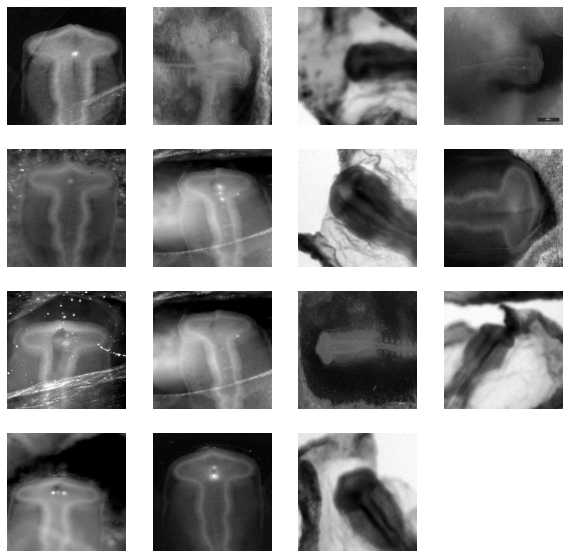

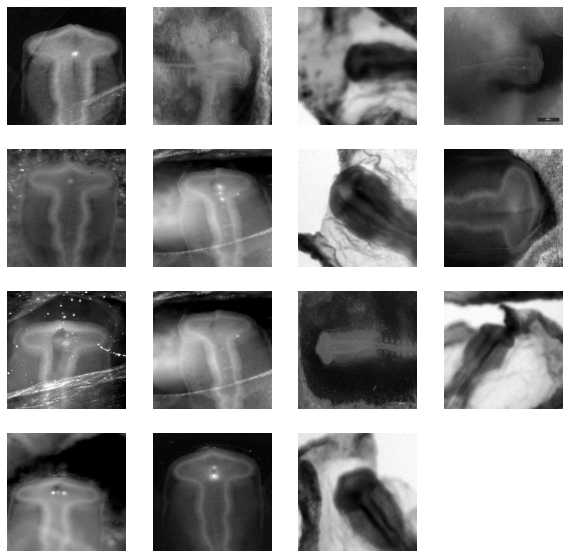

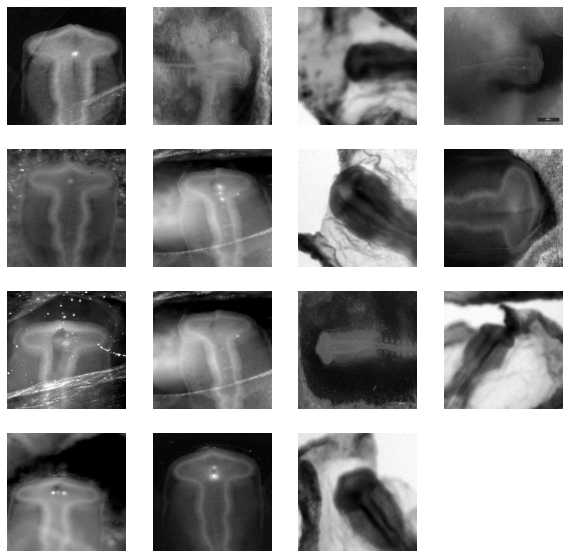

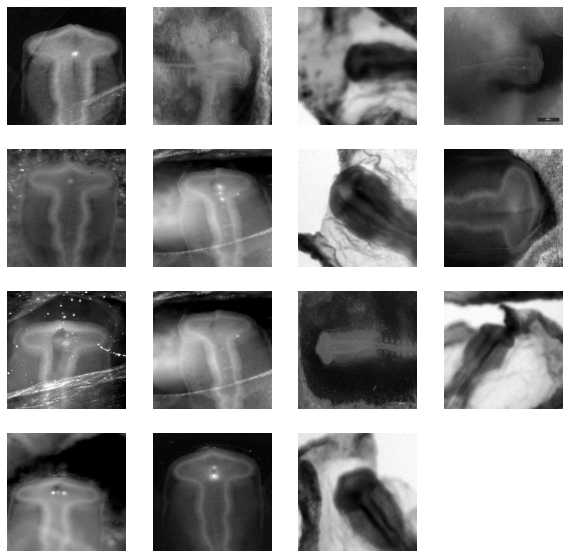

In [ ]:
search_result = gp_minimize(func=opt,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=15,
                            x0 = default_parameters)